In [2]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

con = sqlite3.connect('database.sqlite')
filtered_data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3""",con)

def partition(x): #Function to return positive and negative values for score greater than 3 and less than 3 respectively.
    if x>3:
        return 'Positive'
    return 'Negative'

actualScore = filtered_data['Score']
PositiveNegative = actualScore.map(partition) 
filtered_data['Score'] = PositiveNegative

print(filtered_data.shape)
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


**Observation:**
We load the database from SQL file and replace number based score with Positive or Negative.

# Data Cleaning

In [3]:
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final = sorted_data.drop_duplicates(subset={"UserId", "ProfileName", "Time", "Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

**Observation:**
The values are sorted and duplicate values are dropped.

In [4]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

**Observations:**
Amount of data retained is displayed.

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con) #Selects the values with ID specified above.

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


**Observations:**
For the above IDs the helpfulness numerator is greater than helpfulness denominator. Hence such data should be removed.

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape) #Considers only the values with helpfulness numerator less than helpfulness denominator
final['Score'].value_counts()

(364171, 10)


Positive    307061
Negative     57110
Name: Score, dtype: int64

**Observations:**
The number of positive and negative reviews are printed. We can observe that this is an imbalanced dataset.

In [7]:
check_data=pd.DataFrame(data=final)
print(any(check_data['Text'].duplicated()))  #Check for duplicated values in the given column. Returns either True or False.
print(any(check_data['Id'].duplicated()))
print(any(check_data['Time'].duplicated()))
print(any(check_data['Summary'].duplicated()))

True
False
True
True


**Observation:**
We can observe that Summary is duplicated.

In [8]:
check_data["Summary is duplicated"]= check_data['Summary'].duplicated() #Creates a new column and adds values of duplicated or not.
g = check_data.groupby('Summary is duplicated')
g.get_group(True).head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Summary is duplicated
138687,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,Positive,1210809600,A classic,Get the movie or sound track and sing along wi...,True
157811,171122,7310172001,AF44MU313L704,"H. Ernst ""her_nst""",0,0,Positive,1298332800,Great!,Our dog loves this stuff. Ground up and sprin...,True
157854,171165,7310172001,A1DIS7PF5AA5V2,"MeeMaa ""Gramma""",0,0,Positive,1217548800,Great product,I use to buy this at PetSmart...they no longer...,True
157930,171246,7310172001,A26DDK7ACX8QKK,Donna C. Bondioli,0,0,Positive,1340928000,Dogs Love It,I've been buying this product for over 10 yrs....,True
157954,171271,7310172001,A2LN4UD395G2B6,Chwychuro,0,0,Positive,1320192000,Great Treat,This is great! The price is better than any st...,True


**Observations:**
Realised Summary can be same sometimes, but found that some ProductIDs are not starting with B.

In [9]:
check_data = check_data[check_data.ProductId.str.startswith('B')==True] #Considers productID only starting with B.
check_data.drop(columns=['Summary is duplicated'],inplace=True) #Removes the extra column created above.
final=check_data
print(final.shape)

(363967, 10)


**Observations:**
The final dataframe is obtained removing all the extra values.

In [10]:
check_data['Score'].value_counts()

Positive    306864
Negative     57103
Name: Score, dtype: int64

**Observations:**
The number of positive and negative values are once again checked.

In [11]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))): #Finds sentences containing HTML tags
        print(i)
        print(sent)
        break;
    i += 1;

2
We had a problem with a lot of fruit flies in our kitchen.  I picked up one of these to take care of business despite spotty reviews.  Oops.<br /><br />We had it up for several days and I saw one fly land on it the entire time.  The best part of this tragic story is that when I picked up the trap to investigate the one trapped fly...I'l be darned if that fly didn't pick up his feet and take off. That's right, the fly flew away after landing on this.  None of the other flies in the area even bothered.<br /><br />They should call this the "sucker" trap.  The sucker in this case would be me.  Save your money and invest in quicker hand reflexes.


**Observations:**
We can see that there are 2 such sentences with HTML tags.

In [12]:
stop = set(stopwords.words('english')) #Set of stopwords
sno = nltk.stem.SnowballStemmer('english') #Initialising the snowball stemmer

def cleanhtml(sentence): #Function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #Function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('devastating'))

{"didn't", 'your', 're', 'myself', 'few', 'their', 'y', "won't", 'have', 'having', 'being', 'any', 'through', 'out', "you'll", 'is', 'o', 'needn', 'by', 'down', 'why', 'his', "it's", 'its', 'off', 'each', 'haven', 'during', 'above', 'won', 'now', "needn't", "hadn't", 'what', "shouldn't", 'i', 'own', 'will', 'yourselves', 'll', "couldn't", 'has', 'them', 'but', 'once', 'where', "wouldn't", 'only', 'was', 'at', 'herself', 'should', 'my', 'does', 'which', "mightn't", 'do', 'into', 'doesn', 'itself', "mustn't", "hasn't", 'ain', 'hers', 'after', 've', 'yours', 'than', 'yourself', 'as', 'between', 'to', 'same', 'nor', "doesn't", 'when', 'himself', "that'll", 'with', 'over', 'against', 'other', 'themselves', 'our', 'those', 'couldn', 'from', 'until', 'hadn', 'the', 'most', 'doing', 'these', 'just', 'under', 'about', 'because', 'for', "she's", 'did', "don't", 'be', 'were', 'all', 'weren', 'before', 'both', "aren't", "you've", 'on', 'hasn', 'him', 'can', 'wasn', 'here', "you'd", 'more', 'not', 

In [52]:
sno = nltk.stem.SnowballStemmer('english')
i=0
str1=' '
final_string=[]
all_positive_words=[] # Store words from +ve reviews here
all_negative_words=[] # Store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # Remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'Positive': 
                        all_positive_words.append(s) #List of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'Negative':
                        all_negative_words.append(s) #List of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #Final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [17]:
final['CleanedText']=final_string #Adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

**Observations:**
We remove all the stop words and clean the data. Cleaned words are stored in a new column 'CleanedText'.

In [21]:
final.head(3) #Below the processed review can be seen in the CleanedText Column 


# Store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

**Observations:**
Save this dataframe into an SQL database.

In [21]:
score = final['Score']
print(score.value_counts())

Positive    306864
Negative     57103
Name: Score, dtype: int64


# TSNE

In [22]:
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_1000 = pos.iloc[0:1000,:] #Gets 1000 reviews of positive and negative scores
neg_1000 = neg.iloc[0:1000,:]
grouped_data = pd.concat([pos_1000, neg_1000], ignore_index = True) #This data now contains positive and negative data in order.
print(grouped_data.shape)
grouped_data.head()
score = grouped_data['Score']
print(score.shape)

(2000, 11)
(2000,)


## Bag of words

In [80]:
count_vector=CountVectorizer()
data = count_vector.fit_transform(grouped_data['CleanedText'].values) #To convert a collection of text to a matrix of counts.
print("The type of count vectorizer is ",type(data))
print("The shape of BOW vectorizer is ",data.get_shape())
print("The number of unique words are ", data.get_shape()[1])

The type of count vectorizer is  <class 'scipy.sparse.csr.csr_matrix'>
The shape of BOW vectorizer is  (2000, 7149)
The number of unique words are  7149


**Observations:**
A sparse matrix is created from the cleaned text.

In [85]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(data) #It gets the mean, variance and performs standardization.
print(standardized_data.get_shape())
svd = TruncatedSVD(n_components=2, n_iter=100) #Dimensionality reduction of a sparse matrix to 2 dimensions.
red_data = svd.fit_transform(standardized_data)
print(red_data.shape)

(2000, 7149)
(2000, 2)


**Observations:**
The data is standardised and dimensionality reduction techniques are performed upon.

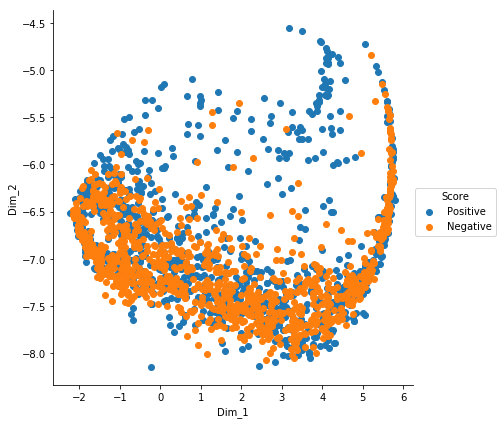

In [86]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity = 1000) #Initialise a TSNE plot with required prerequisites
tsne_data=model.fit_transform(red_data)

tsne_data = np.vstack((tsne_data.T, score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

**Observations:**
There is a lot of overlapping between positive and negative scores.

## Bi grams and n grams

In [53]:
freq_dist_positive=nltk.FreqDist(all_positive_words) #Computes the frequency distribution of the givrn input.
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 139381), (b'tast', 129040), (b'good', 112734), (b'flavor', 109616), (b'love', 107223), (b'use', 103814), (b'great', 103803), (b'one', 96674), (b'product', 90970), (b'tri', 86771), (b'tea', 83888), (b'coffe', 78812), (b'make', 75079), (b'get', 72070), (b'food', 64771), (b'would', 55537), (b'time', 55227), (b'buy', 54172), (b'realli', 52694), (b'eat', 51975)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32329), (b'product', 28214), (b'one', 20565), (b'flavor', 19575), (b'would', 17968), (b'tri', 17753), (b'use', 15301), (b'good', 15040), (b'coffe', 14716), (b'get', 13785), (b'buy', 13747), (b'order', 12870), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11084), (b'box', 10844), (b'amazon', 10071), (b'make', 9839)]


**Observations:**
All the most frequent positive and negative words are computed.

In [54]:
count_vect = CountVectorizer(ngram_range=(1,2) ) #This builds unigrams and bigrams.
final_bigram_counts = count_vect.fit_transform(grouped_data['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (2000, 75859)
the number of unique words including both unigrams and bigrams  75859


**Observations:**
The number unique words including unigrams and bigrams are computed. This data is not standardised and has high features.

In [56]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(final_bigram_counts) #It gets the mean, variance and performs standardization.
print(standardized_data.get_shape())
svd = TruncatedSVD(n_components=2, n_iter=100) #Dimensionality reduction of a sparse matrix to 2 dimensions.
red_data = svd.fit_transform(standardized_data)
print(red_data.shape)

(2000, 75859)
(2000, 2)


**Observations:**
The data is standardised and features are reduced to 2.

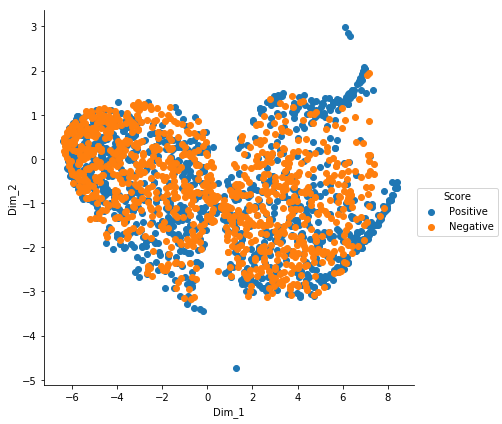

In [57]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity = 700) #Initialise a TSNE plot with required prerequisites
tsne_data=model.fit_transform(red_data)

tsne_data = np.vstack((tsne_data.T, score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

**Observations:**
A lot of overlapping between positive and negative points is observed.

## TF-IDF

In [23]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(grouped_data['CleanedText'].values) #Converts to a sparse matrix of TF-IDF vectors.
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (2000, 75859)
the number of unique words including both unigrams and bigrams  75859


**Observations:**
A sparse matrix is formed with included Unigrams and Bigrams.

In [88]:
features = tf_idf_vect.get_feature_names() #This gets the features present in the TF-IDF vectors.
print('Some unique sample features are ', features[1500:1510])

Some unique sample features are  ['along fun', 'along galileo', 'along great', 'along inhal', 'along line', 'along main', 'along money', 'along neighbor', 'along new', 'along nightmar']


In [89]:
def top_tfidf_feats(row, features, top_n=25): #Function to return top values of TF-IDF out of a given number of values.
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['Feature', 'TF-IDF']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

**Observations:**
Top 25 features sorted by their TF-IDF value can be observed.

In [90]:
top_tfidf

,Feature,TF-IDF
0,fli,0.240557
1,gone may,0.168422
2,avoid touch,0.168422
3,surfac sticki,0.168422
4,bought apart,0.168422
5,practic gone,0.168422
6,sticki tri,0.168422
7,one surfac,0.168422
8,fli drive,0.168422
9,may long,0.168422


In [92]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(final_tf_idf) #It gets the mean, variance and performs standardization.
print(standardized_data.get_shape())
svd = TruncatedSVD(n_components=2, n_iter=100) #Dimensionality reduction of a sparse matrix to 2 dimensions.
red_data = svd.fit_transform(standardized_data)
print(red_data.shape)
#dense_data = standardized_data.todense(order=None, out=None)

(2000, 75859)
(2000, 2)


**Observations:**
The data is standardised and dimensionality reduction techniques are performed upon.

T-SNE Done! Time elapsed : 330.72977113723755seconds


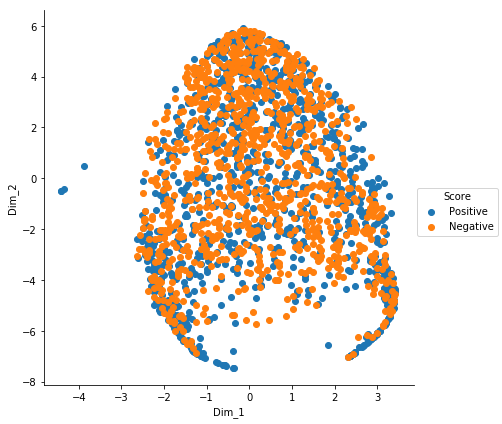

In [96]:
import time
from sklearn.manifold import TSNE
time_start = time.time() #Calculates the time taken to perform this operation
model = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity = 750) #Initialise the TSNE plot
tsne_data=model.fit_transform(red_data)
print('T-SNE Done! Time elapsed : {}seconds'.format(time.time()-time_start))

tsne_data = np.vstack((tsne_data.T, score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

**Observations:**
Most of the positive and negative scores are overlapping a lot.

## Word2Vec

In [97]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) #Implements word vectors and their similarity.
print("the vector representation of word 'computer'",model.wv['computer'])
print("the similarity between the words 'woman' and 'man'",model.wv.similarity('woman', 'man'))
print("the most similar words to the word 'woman'",model.wv.most_similar('woman'))

the vector representation of word 'computer' [ 1.07421875e-01 -2.01171875e-01  1.23046875e-01  2.11914062e-01
 -9.13085938e-02  2.16796875e-01 -1.31835938e-01  8.30078125e-02
  2.02148438e-01  4.78515625e-02  3.66210938e-02 -2.45361328e-02
  2.39257812e-02 -1.60156250e-01 -2.61230469e-02  9.71679688e-02
 -6.34765625e-02  1.84570312e-01  1.70898438e-01 -1.63085938e-01
 -1.09375000e-01  1.49414062e-01 -4.65393066e-04  9.61914062e-02
  1.68945312e-01  2.60925293e-03  8.93554688e-02  6.49414062e-02
  3.56445312e-02 -6.93359375e-02 -1.46484375e-01 -1.21093750e-01
 -2.27539062e-01  2.45361328e-02 -1.24511719e-01 -3.18359375e-01
 -2.20703125e-01  1.30859375e-01  3.66210938e-02 -3.63769531e-02
 -1.13281250e-01  1.95312500e-01  9.76562500e-02  1.26953125e-01
  6.59179688e-02  6.93359375e-02  1.02539062e-02  1.75781250e-01
 -1.68945312e-01  1.21307373e-03 -2.98828125e-01 -1.15234375e-01
  5.66406250e-02 -1.77734375e-01 -2.08984375e-01  1.76757812e-01
  2.38037109e-02 -2.57812500e-01 -4.46777344e

**Observation:**
This model from Google gives us a vector representation of a word and their similarity to other words.

In [103]:
print("the similarity between the words 'mother' and 'father'",model.wv.similarity('mother', 'father'))
print("the most similar words to the word 'book'",model.wv.most_similar('book'))

the similarity between the words 'mother' and 'father' 0.7901483043348326
the most similar words to the word 'book' [('tome', 0.7485830783843994), ('books', 0.7379177808761597), ('memoir', 0.730292797088623), ('paperback_edition', 0.6868364810943604), ('autobiography', 0.6741527318954468), ('memoirs', 0.6505153179168701), ('Book', 0.6479282379150391), ('paperback', 0.6471226811408997), ('novels', 0.6341458559036255), ('hardback', 0.6283079385757446)]


In [25]:
list_of_sent=[]
for sent in final['CleanedText'].values: #Splits sentences into words and stores it in a list
    list_of_sent.append(sent.split())

In [26]:
print(final['CleanedText'].values[2])
print("*****************************************************************")
print(list_of_sent[2])

problem lot fruit fli kitchen pick one take care busi despit spotti review oop sever day saw one fli land entir time best part tragic stori pick trap investig one trap fli darn fli didnt pick feet take that right fli flew away land none fli area even bother call sucker trap sucker case would save money invest quicker hand reflex
*****************************************************************
['problem', 'lot', 'fruit', 'fli', 'kitchen', 'pick', 'one', 'take', 'care', 'busi', 'despit', 'spotti', 'review', 'oop', 'sever', 'day', 'saw', 'one', 'fli', 'land', 'entir', 'time', 'best', 'part', 'tragic', 'stori', 'pick', 'trap', 'investig', 'one', 'trap', 'fli', 'darn', 'fli', 'didnt', 'pick', 'feet', 'take', 'that', 'right', 'fli', 'flew', 'away', 'land', 'none', 'fli', 'area', 'even', 'bother', 'call', 'sucker', 'trap', 'sucker', 'case', 'would', 'save', 'money', 'invest', 'quicker', 'hand', 'reflex']


**Observations:**
Prints the corresponding split words in a given review.

In [28]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4) #Initialises the Word2Vec model with words occuring more than 5 times.

In [30]:
w2v_words = list(w2v_model.wv.vocab) #This gives a dictionary of words which tells about the uniqueness of a word among other things.
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[168:185])

number of words that occured minimum 5 times  21929
sample words  ['might', 'two', 'differ', 'apart', 'manag', 'swat', 'someth', 'suppos', 'flys', 'couldnt', 'less', 'month', 'mayb', 'miniscul', 'fraction', 'local', 'hardwar']


**Observations:**
We can see the number of times a word occured minimum 5 times.

In [132]:
w2v_model.wv.most_similar('tasti') #This gives the similarity of one word to another

[('delici', 0.8048410415649414),
 ('yummi', 0.7839305996894836),
 ('tastey', 0.7628130912780762),
 ('nutriti', 0.6889693737030029),
 ('satisfi', 0.6806626319885254),
 ('good', 0.6769177913665771),
 ('hearti', 0.6638391017913818),
 ('delish', 0.645478367805481),
 ('nice', 0.6433511972427368),
 ('versatil', 0.6424300670623779)]

**Observations:**
This gives the words most similar to the word input above.

In [165]:
w2v_model.wv['until']

array([ 0.18539149, -0.03461658, -0.34673363,  0.06805123, -0.10499727,
        0.1871839 , -0.1356358 , -0.09481326, -0.03571059,  0.6065498 ,
       -0.07279619,  0.18746164, -0.05580921,  0.13607621,  0.24754295,
        0.02724264,  0.06638001, -0.13061476,  0.19128886, -0.23517911,
        0.04844778, -0.14434597,  0.18505254,  0.026427  , -0.23602875,
        0.23390593,  0.08847811,  0.10385825,  0.23575029,  0.07537769,
        0.1648775 , -0.27473032,  0.20512486, -0.28774852,  0.11925064,
       -0.11923316, -0.10220491,  0.6221496 , -0.25233126, -0.10938031,
       -0.00616616, -0.30863595, -0.1676918 , -0.17908323,  0.4086401 ,
       -0.05275666, -0.26210597,  0.10983319,  0.10211024, -0.07968684],
      dtype=float32)

In [48]:
sent_vectors = [];
sent_list = []
for sent in grouped_data['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # For a sentence in the previously created list of sentences
    sent_vec = np.zeros(50) # As word vectors are of zero length, returns an array of size 50 filled with zeros
    i = 0; # Number of words with a valid vector in the sentence/review
    for word in sent: # For each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word] #Gets the corresponding vector for the word
            sent_vec += vec
            i += 1
    if i != 0:
        sent_vec /= i
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

2000
50


**Observations:**
We are creating a vector for each word in our 2000 point dataframe and saving it as a list.

In [49]:
standardized_data = StandardScaler(with_mean=False).fit_transform(sent_vectors)

**Observations:**
This standardizes the list of vectors.

T-SNE Done! Time elapsed : 391.98030161857605seconds


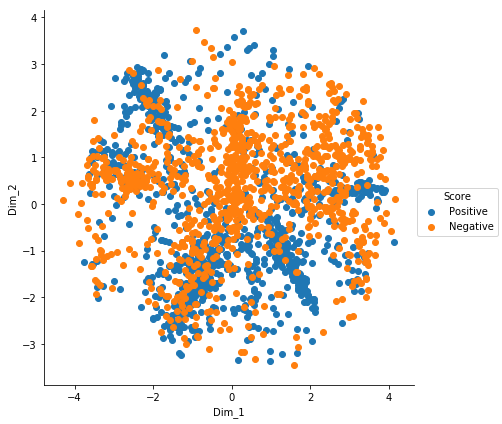

In [50]:
import time
from sklearn.manifold import TSNE
time_start = time.time() #Calculates the time taken to perform this operation.
model = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity = 750) #Initialises the TSNE plot.
tsne_data=model.fit_transform(standardized_data)
print('T-SNE Done! Time elapsed : {}seconds'.format(time.time()-time_start))

tsne_data = np.vstack((tsne_data.T, score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

**Observations:**
There is a lot of overlapping of positive and negative points.

## TF-IDF Word2Vec

In [39]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
tf_final_idf = tf_idf_vect.fit_transform(grouped_data['CleanedText'].values)
new_sent_list = []
for sent in grouped_data['CleanedText'].values:
    new_sent_list.append(sent.split())

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in new_sent_list: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            try:
                vec = w2v_model.wv[word] # obtain the tf_idfidf of a word in a sentence/review
                tf_idf = tf_final_idf[row, tfidf_feat.index(word)]
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
tfidf_sent_vectors[2]

array([-0.48961756,  1.52139191,  1.53019016,  1.4738405 ,  0.70845479,
       -1.66380338, -2.70936823, -1.29624395, -0.11763255,  0.44661646,
        0.70011934, -0.65920017, -1.45247368, -0.85791577,  0.40219895,
        0.98482454, -1.18528504,  0.82880318,  0.94473822, -0.95823908,
       -0.26474355, -1.69039819,  0.98332832,  0.40007559, -0.99935578,
       -0.09270791, -0.58815978,  0.04913006, -1.58275779, -1.10219748,
       -0.20108453, -0.1697837 , -0.46701717,  0.72568704, -1.11017165,
        1.25624642,  1.08672102,  0.20665315, -0.21386551, -1.30775825,
        0.06069361, -0.58128757,  0.21973841,  0.12917585, -1.15837976,
        0.23216515,  0.56684191, -1.1306098 ,  0.49577006,  1.36406447])

In [45]:
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

2000
50


In [41]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(tfidf_sent_vectors)

T-SNE Done! Time elapsed : 364.6959431171417seconds


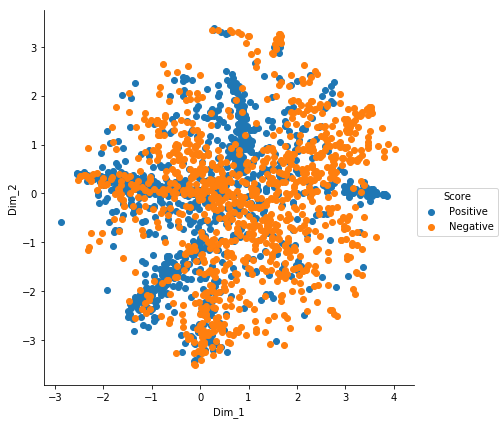

In [47]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
model = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity = 900)
tsne_data=model.fit_transform(standardized_data)
print('T-SNE Done! Time elapsed : {}seconds'.format(time.time()-time_start))

tsne_data = np.vstack((tsne_data.T, score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

**Observations:**
We can observe a lot of overlapping of positive and negative points.

# Result

1) The bag of words plot is overlapping a lot to distinguish between positive and negative scores.

2) Average Word2Vec and TF-IDF Word2Vec though overlapping a lot provide better results to distinguish between positive and negative scores.